In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy import sparse
import json
from datetime import datetime
import warnings

import pcg_skel
from cloudvolume import CloudVolume
from caveclient import CAVEclient

In [43]:
euc_dist_step = 100 * 1000
path_dist_step = 100 * 1000
nsteps = 1000
cache_dir = "..\\data\\"
pre_type = "5P_IT"
max_hist_dist = 2_000_000
num_syns_cutoff = 100
split_quality_cutoff = 0.5
require_in_col = False
inh_cell_types = ["BPC", "BC", "MC", "NGC"]

datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)

In [44]:
# client.auth.get_new_token()  # <-- use this the first time to get a token
# client.auth.save_token( )

## Find a layer 2/3 pyramidal cell that's been proofread to investigate

In [45]:
all_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")
all_cells["num_soma"] = all_cells.groupby("pt_root_id").transform("count")["valid"]
cells_by_root = all_cells.copy()
cells_by_root.index = cells_by_root.pt_root_id
cells_by_nuc = all_cells.copy()
cells_by_nuc.index = cells_by_nuc.id

In [157]:
# use this cell if you want to go through the cells one at a time
# gather a list of thoroughly proofread layer 2/3 pyramidal cells
proofreading_status = client.materialize.query_table('proofreading_status_public_release')
proofread_cells = proofreading_status.query("(status_axon == 'extended' or status_axon == 'clean') and valid_id == pt_root_id")
pre_type_cells = all_cells.query(f"cell_type == '{pre_type}'")
# proofread_cells = client.materialize.query_table('proofreading_functional_coreg_v2')
root_ids_to_study = list(set.intersection(set(pre_type_cells.pt_root_id.unique()), set(proofread_cells.valid_id.unique())))
nucs_to_study = list(cells_by_root.id.loc[root_ids_to_study].values)  # permanent nucleus id of cell
print(len(root_ids_to_study), len(nucs_to_study))
if len(root_ids_to_study) != len(nucs_to_study):
    raise ValueError("Some cells were not proofread properly")

In [158]:
# nuc_id = nucs_to_study.pop()  # look at the next thoroughly proofread layer 2/3 pyramidal cell
# cell_root_id = cells_by_nuc.pt_root_id.loc[nuc_id]
# cell_root_id, nuc_id

In [159]:
# nucs_to_study = list(set.difference(set(nucs_to_study), {493968, 518632, 520182, 553325, 555010, 582388, 582409, 610615}))

In [160]:
# cells_str = ",\n".join(map(str, nucs_to_study))
# with open("clean_cells.txt", "w") as f:
#     f.write(cells_str)

In [161]:
# run this command to run this notebook for all 20 cells
# for /l %x in (1, 1, 18) do jupyter nbconvert --to notebook --execute --inplace --allow-errors synapse_analysis.ipynb
with open("clean_cells.txt", "r") as f:  # cells.txt is just a list of the 20 proofread cells above
    nucs_to_study = list(map(int, f.read().split(",\n")))

nuc_id = nucs_to_study.pop()  # look at the next thoroughly proofread layer 2/3 pyramidal cell
cell_root_id = cells_by_nuc.pt_root_id.loc[nuc_id]
cells_str = ",\n".join(map(str, nucs_to_study))
print(cell_root_id, nuc_id)
with open("clean_cells.txt", "w") as f:  
    f.write(cells_str)

ValueError: invalid literal for int() with base 10: ''

In [125]:
cell_data = all_cells.query(f"pt_root_id == {cell_root_id}")
root_point = cell_data['pt_position'].iloc[0]
cell_data

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position,num_soma
63222,493419,t,aibs_coarse_excitatory,5P_IT,104864067013122239,864691135865773189,"[291680, 169776, 22275]",1


### Set up storage of results

In [126]:
results_dict = {"parameters": {"pre_type": pre_type, "split_quality_cutoff": split_quality_cutoff, "num_syns_cutoff": num_syns_cutoff, "nsteps": nsteps, "max_hist_dist": max_hist_dist, "euc_dist_step": euc_dist_step, "path_dist_step": path_dist_step, "require_in_col": require_in_col}}
results_fname = str(nuc_id) + "_" + str(datetime.now()).replace(" ", "_").replace(":", ".")
results_dir = os.path.join(cache_dir, "results", "5P_IT-clean-subclass")
results_path = os.path.join(results_dir, results_fname + ".json")

In [127]:
# bounding box of the column we're interested in
# bbox = [[ 672444, 200000, 805320], [ 772444, 1294000, 905320]]  # nm
resolution = np.array([4., 4., 40.])
bbox = [[ 672444 // 4, 200000 // 4, 805320 // 40], [ 772444 // 4, 1294000 // 4, 905320 // 40]]  # vx
def in_bbox(p):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

col_cells = all_cells[all_cells.pt_position.apply(in_bbox)]

## Get the neuron

In [128]:
nrn_cache_dir = os.path.join(cache_dir, "nrns")
try:
    print("Loading neuron from cache...", end="")
    nrn = pcg_skel.meshwork.load_meshwork(os.path.join(nrn_cache_dir, str(nuc_id) + '.h5'))
    print(" successful.")
except FileNotFoundError as e:
    print(" cached skeleton not found. Generating skeleton.")
    print("\t", e)
    nrn = pcg_skel.pcg_meshwork(
                    cell_root_id,
                    client=client,
                    root_point=root_point,
                    root_point_resolution=[4, 4, 40],
                    collapse_soma=True,
                    invalidation_d=3,
                    synapse_table='synapses_pni_2',
                    synapses="all",
                    refine='all',
                    cache=os.path.join(cache_dir, "l2lookup.sqlite"),
                    save_to_cache=True
                )
    nrn.save_meshwork(os.path.join(nrn_cache_dir, str(nuc_id) + '.h5'))

# find the synapses on the axon
is_axon, split_quality = pcg_skel.meshwork.algorithms.split_axon_by_synapses(
    nrn, nrn.anno.pre_syn.skel_index, nrn.anno.post_syn.skel_index
)
nrn.anno.add_annotations("is_axon", is_axon, mask=True)
if split_quality < split_quality_cutoff:
    raise ValueError("Axon may not have been found")
split_quality

Loading neuron from cache... cached skeleton not found. Generating skeleton.
	 [Errno 2] Unable to open file (unable to open file: name = '..\data\nrns\493419.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


100%|█████████████████████████████████████████████████████████████████████████| 12136/12136 [00:00<00:00, 17690.97it/s]


0.6679953068319056

In [129]:
output_df = nrn.anno.pre_syn.df
output_df["skel_idx"] = nrn.anno.pre_syn.mesh_index.to_skel_index_padded  # maps to the index of the nearest skeleton vertex
output_df = output_df[nrn.anno.is_axon.mesh_mask[output_df.pre_pt_mesh_ind]] # only look at synapses on the axon, because those on the dendrites are mislabelled

## Clean the data further

In [130]:
roots_with_soma = set(cells_by_root.index)

In [131]:
# not falsely merged
#                   root_id is of a cell       and there is only 1 soma associated with it
include = np.array([root_id in roots_with_soma and type(cells_by_root.id.loc[root_id]) == np.int64 for root_id in output_df.post_pt_root_id])
if require_in_col:
    # in column
    col_ids = set(col_cells.pt_root_id.values)
    include &= np.array([c in col_ids for c in output_df.post_pt_root_id])
# other possible criteria: proofread, in one of the other tables

# finally filter by the above criteria
clean_output_df = output_df[include].copy()

if len(clean_output_df.post_pt_root_id) < num_syns_cutoff:  # skip if there are unreasonably few clean connections
    raise ValueError("Not enough clean synapses")

In [132]:
# convert to json serializable format
clean_output_df = pd.read_json(clean_output_df.to_json())

# Count its synapse types

In [133]:
# # Look at a pyramidal neuron, count its synapse types
def get_prop_type(target_cells, cell_type):
    # target cells are intentionally not necessarily unique
    cell_types = cells_by_root.cell_type.loc[target_cells]
    print("n =", len(cell_types))
    return sum(cell_types.values == cell_type) / len(cell_types) if len(cell_types) > 0 else np.nan

for cell_type in inh_cell_types:
    p = get_prop_type(target_cells=clean_output_df.post_pt_root_id, cell_type=cell_type)
    print(f"post syn {cell_type} proportion given pre is 23P:", p)
    results_dict[f"post_syn_{cell_type}_given_pre_23P"] = {"p": p, "n": len(clean_output_df.post_pt_root_id)}

n = 265
post syn BPC proportion given pre is 23P: 0.04150943396226415
n = 265
post syn BC proportion given pre is 23P: 0.2
n = 265
post syn MC proportion given pre is 23P: 0.12452830188679245
n = 265
post syn NGC proportion given pre is 23P: 0.0


## Soma-to-soma distance

In [134]:
def vx_to_nm(p):
    return p * resolution

def soma_to_soma_dist(post_id):
    possible = cells_by_root.loc[post_id]
    if possible.num_soma > 1: # falsely merged cell (shouldn't happen if data is clean)
        print("false merge")
        return np.nan
    if possible.num_soma == 0: 
        print("no nucleus associated with post-synapse")
        return np.nan
    post_loc = vx_to_nm(possible.pt_position)
    return np.sqrt(np.sum((post_loc - soma_loc) ** 2))

soma_loc = vx_to_nm(cell_data.pt_position.iloc[0])
clean_output_df["soma_to_soma_dist"] = clean_output_df.post_pt_root_id.apply(soma_to_soma_dist)
clean_output_df

,id,valid,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,size,pre_pt_position,post_pt_position,ctr_pt_position,pre_pt_level2_id,pre_pt_mesh_ind,skel_idx,soma_to_soma_dist
0,357282550,t,105428322837645673,864691135865773189,105428322837596352,864691135975459907,10484,"[295650, 179454, 23556]","[295676, 179448, 23556]","[295658, 179460, 23556]",177485916875522058,6847,3541,92336.259227
1,395601192,t,108388070767819718,864691135865773189,108388070767810999,864691136134445707,308,"[317404, 211410, 24100]","[317336, 211438, 24095]","[317364, 211425, 24095]",180445664805650442,10895,5552,336212.565524
2,346511507,t,104443778626183159,864691135865773189,104443778626179958,864691135337724646,14796,"[288534, 184114, 21656]","[288414, 184200, 21650]","[288468, 184166, 21653]",176501372663890226,4724,2520,71483.136809
5,332543868,t,103389072164365848,864691135865773189,103389072164362654,864691135181763330,11192,"[280830, 190494, 22211]","[280794, 190394, 22204]","[280844, 190440, 22202]",175446666202055152,2719,1676,96320.973085
6,393207140,t,108521730150387898,864691135865773189,108521798869851296,864691135736328340,9368,"[318440, 158912, 24391]","[318348, 159002, 24388]","[318374, 159010, 24387]",180579324187902634,10996,5628,153190.180782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,300684018,t,100365483773273280,864691135865773189,100365483773271348,864691135850420423,216,"[258676, 207176, 21195]","[258756, 207162, 21198]","[258690, 207206, 21200]",172423077810930029,832,590,216198.668932
445,393526591,t,108171191562771687,864691135865773189,108171191562764333,864691135684560020,4064,"[315690, 168200, 20386]","[315788, 168344, 20376]","[315766, 168276, 20378]",180228785600201676,10688,5414,94394.176092
449,326996119,t,102963630219442088,864691135865773189,102893261475254551,864691136965802190,3752,"[277572, 166162, 24758]","[277520, 166178, 24765]","[277536, 166132, 24762]",175021224257126829,2236,1411,147415.326205
450,182141507,t,90865703980528124,864691135865773189,90865703980519332,864691135730372025,8204,"[189522, 207050, 26466]","[189574, 207050, 26460]","[189536, 207022, 26464]",162923298018034380,60,40,452586.418674


# Find the distance from the soma to each synapse (euclidean, then dijkstra)
## Euclidean

In [135]:
ctr_locs = np.stack(clean_output_df.ctr_pt_position.apply(vx_to_nm).values)
clean_output_df["euc_dist"] = np.sqrt(np.sum((ctr_locs - soma_loc.reshape(1, 3))**2, axis=1))

## Path-length

In [136]:
skel_vertices = nrn.skeleton.vertices
skel_csgraph = nrn.skeleton.csgraph
idx_of_soma = int(nrn.skeleton.root)

# csgraph stands for compressed sparse graph
ds = sparse.csgraph.dijkstra(skel_csgraph,
                             directed=False,
                             indices=idx_of_soma)
if not all(np.isfinite(ds)):
    raise RuntimeError("Dijkstra's algorithm on the skeleton did not find a solution")

In [137]:
clean_output_df["path_dist"] = ds[clean_output_df.skel_idx]
# clean_output_df but split into the various cell types
syn_dfs = {"exc": clean_output_df[cells_by_root.classification_system.loc[clean_output_df.post_pt_root_id].values == "aibs_coarse_excitatory"]}
for cell_type in inh_cell_types:
    is_type = cells_by_root.cell_type.loc[clean_output_df.post_pt_root_id].values == cell_type
    syn_dfs[cell_type] = clean_output_df[is_type]

unplotted = clean_output_df[clean_output_df["path_dist"] > max_hist_dist]
if len(unplotted) > 0:
    warnings.warn("Some data is not captured by the histogram")
    print(unplotted)

## Results and Figures!

In [138]:
density = False  # whether to use the counts or density for the histogram
path_bin_edges = np.arange(0, max_hist_dist, path_dist_step)
path_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2
path_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    path_hists[cell_type] = np.histogram(syn_dfs[cell_type].path_dist, bins=path_bin_edges, density=density)[0]

euc_bin_edges = np.arange(0, max_hist_dist, euc_dist_step)
euc_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2
euc_hists = dict()  # cell type -> histogram of counts of that type by distance along axon
for cell_type in syn_dfs:
    euc_hists[cell_type] = np.histogram(syn_dfs[cell_type].euc_dist, bins=euc_bin_edges, density=density)[0]

In [139]:
# contniuously moving bucket to calculate synapse density of each type
# this implementation is a bit slow, but it's not that big a deal
# (I should rather loop over the synapses and increment appropriate counters as I go)
euc_bin_locs = np.linspace(euc_dist_step / 2, max_hist_dist - euc_dist_step / 2, nsteps)
step_size = max_hist_dist / nsteps
path_bin_locs = np.linspace(path_dist_step / 2, max_hist_dist - path_dist_step / 2, nsteps)
euc_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])
path_densities = dict([(cell_type, np.zeros(nsteps)) for cell_type in syn_dfs])

for i in range(nsteps):
    euc_c = euc_bin_locs[i]
    euc_l = euc_c - euc_dist_step / 2
    euc_r = euc_c + euc_dist_step / 2
    for cell_type in syn_dfs:
        euc_densities[cell_type][i] = sum((euc_l < syn_dfs[cell_type].euc_dist).values & (syn_dfs[cell_type].euc_dist < euc_r).values) / euc_dist_step
    path_c = path_bin_locs[i]
    path_l = path_c - path_dist_step / 2
    path_r = path_c + path_dist_step / 2
    for cell_type in syn_dfs:
        path_densities[cell_type][i] = sum((path_l < syn_dfs[cell_type].path_dist).values & (syn_dfs[cell_type].path_dist < path_r).values) / path_dist_step

In [140]:
p_type_by_path_dists = dict()
path_total_density = sum(path_densities[t] for t in path_densities)
for cell_type in path_densities:
    p_type_by_path_dists[cell_type] = path_densities[cell_type] / path_total_density
p_type_by_euc_dists = dict()
euc_total_density = sum(euc_densities[t] for t in euc_densities)
for cell_type in euc_densities:
    p_type_by_euc_dists[cell_type] = euc_densities[cell_type] / euc_total_density


C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\ATMal\miniconda3\envs\ofs\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [141]:
def to_dict_list(d):
    """converts a dictionary of np arrays to a dictionary of lists"""
    return dict([(k, d[k].tolist()) for k in d])
results_dict["euc_hists"] = to_dict_list(euc_hists)
results_dict["path_hists"] = to_dict_list(path_hists)
results_dict["euc_densities"] = to_dict_list(euc_densities)
results_dict["path_densities"] = to_dict_list(path_densities)
results_dict["p_type_by_path_dists"] = to_dict_list(p_type_by_path_dists)
results_dict["p_type_by_euc_dists"] = to_dict_list(p_type_by_path_dists)
results_dict["clean_output_dict"] = clean_output_df.to_dict()
results_dict["syn_dicts"] = dict((key, syn_dfs[key].to_dict()) for key in syn_dfs)

with open(results_path, "w") as f:
    f.write(json.dumps(results_dict))

In [142]:
plot_colors = ["lime", "darkorchid", "gold", "orangered", "dodgerblue"]
type_colors = dict(zip(syn_dfs.keys(), plot_colors))

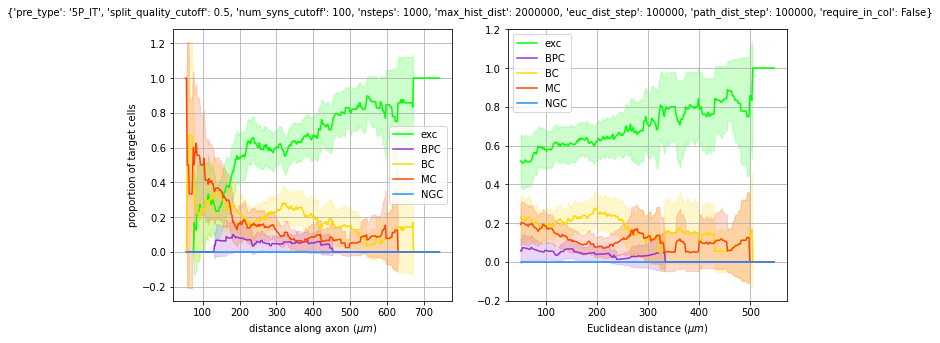

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for cell_type in syn_dfs:
    p = p_type_by_path_dists[cell_type]
    axes[0].plot(path_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    std_hat = np.sqrt(p * (1 - p) / (path_dist_step * path_total_density))
    axes[0].fill_between(path_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("proportion of target cells")
axes[0].legend()
axes[0].grid()
for cell_type in syn_dfs:
    p = p_type_by_euc_dists[cell_type]
    axes[1].plot(euc_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    sem = np.sqrt(p * (1 - p) / (euc_dist_step * euc_total_density))
    axes[1].fill_between(euc_bin_locs/1000, p - 2 * sem, p + 2 * sem, color=type_colors[cell_type], alpha=0.2)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
axes[1].grid()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [144]:
fig.savefig(os.path.join(results_dir, results_fname + "_p_type.png"))

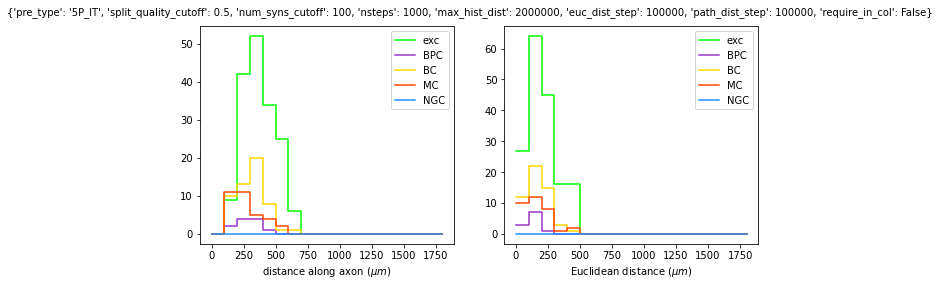

In [145]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in syn_dfs:
    axes[0].step(path_bin_edges[:-1]/1000, path_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].legend()
for cell_type in syn_dfs:
    axes[1].step(euc_bin_edges[:-1]/1000, euc_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [146]:
fig.savefig(os.path.join(results_dir, results_fname + "_hists.png"))

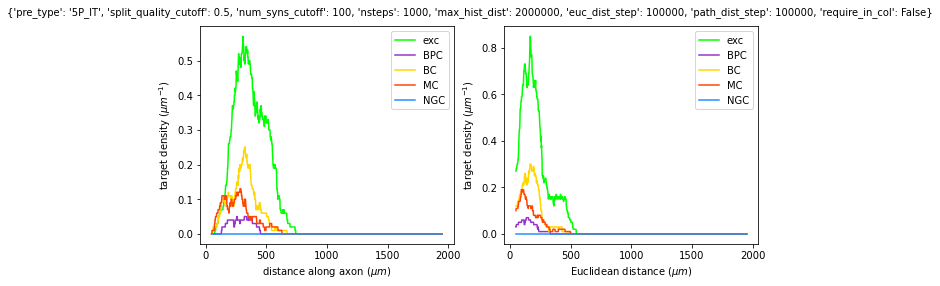

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in syn_dfs:
    axes[0].plot(path_bin_locs/1000, 1000*path_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("target density ($\mu m^{-1}$)")
axes[0].legend()
for cell_type in syn_dfs:
    axes[1].plot(euc_bin_locs/1000, 1000*euc_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].set_ylabel("target density ($\mu m^{-1}$)")
axes[1].legend()
fig.text(.5, 0.92, str(results_dict["parameters"]), ha="center")
plt.show()

In [148]:
fig.savefig(os.path.join(results_dir, results_fname + "_densities.png"))

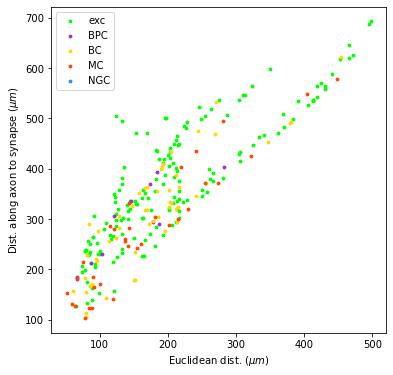

In [149]:
# plot euclidean distance to synapse vs path distance to synapse
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].euc_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("Euclidean dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [150]:
fig.savefig(os.path.join(results_dir, results_fname + "_euc_v_path.png"))

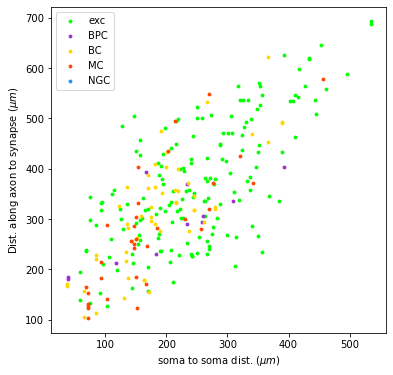

In [151]:
# plot path-distance along axon to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [152]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_path.png"))

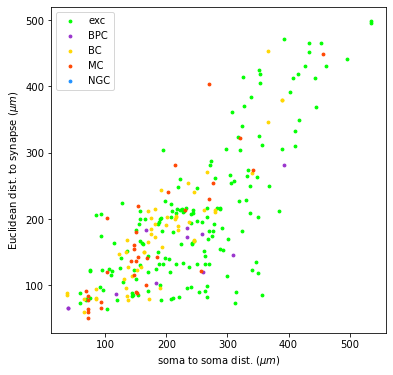

In [153]:
# plot euclidean distance to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].euc_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Euclidean dist. to synapse ($\mu m$)")
plt.legend()
plt.show()

In [154]:
fig.savefig(os.path.join(results_dir, results_fname + "_soma-soma_v_euc.png"))

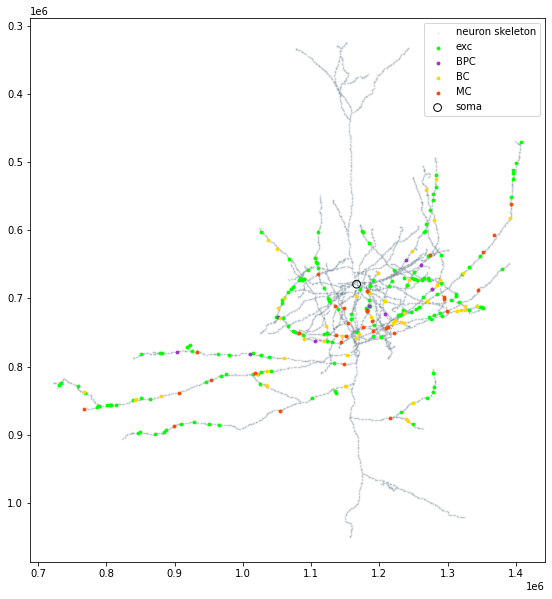

In [155]:
# plot the skeleton
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect(1)
ax.scatter(skel_vertices[:, 0], skel_vertices[:, 1], s=1, alpha=.2, c="lightslategrey", label="neuron skeleton")
for cell_type in syn_dfs:
    syn_locs = syn_dfs[cell_type].pre_pt_position.apply(vx_to_nm).values
    if len(syn_locs) > 0:
        syn_locs = np.stack(syn_locs)
        ax.scatter(syn_locs[:, 0], syn_locs[:, 1], s=8, c=type_colors[cell_type], alpha=1, label=cell_type)
ax.scatter(soma_loc[0], soma_loc[1], s=60, marker="o", facecolors='none', edgecolors='k', label="soma")
ax.invert_yaxis()
plt.legend()
plt.show()

In [156]:
fig.savefig(os.path.join(results_dir, results_fname + "_skeleton.png"))